## CORE

In [27]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

In [28]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 12)
import matplotlib.pyplot as plt

Image Size: (10240, 8192, 3)


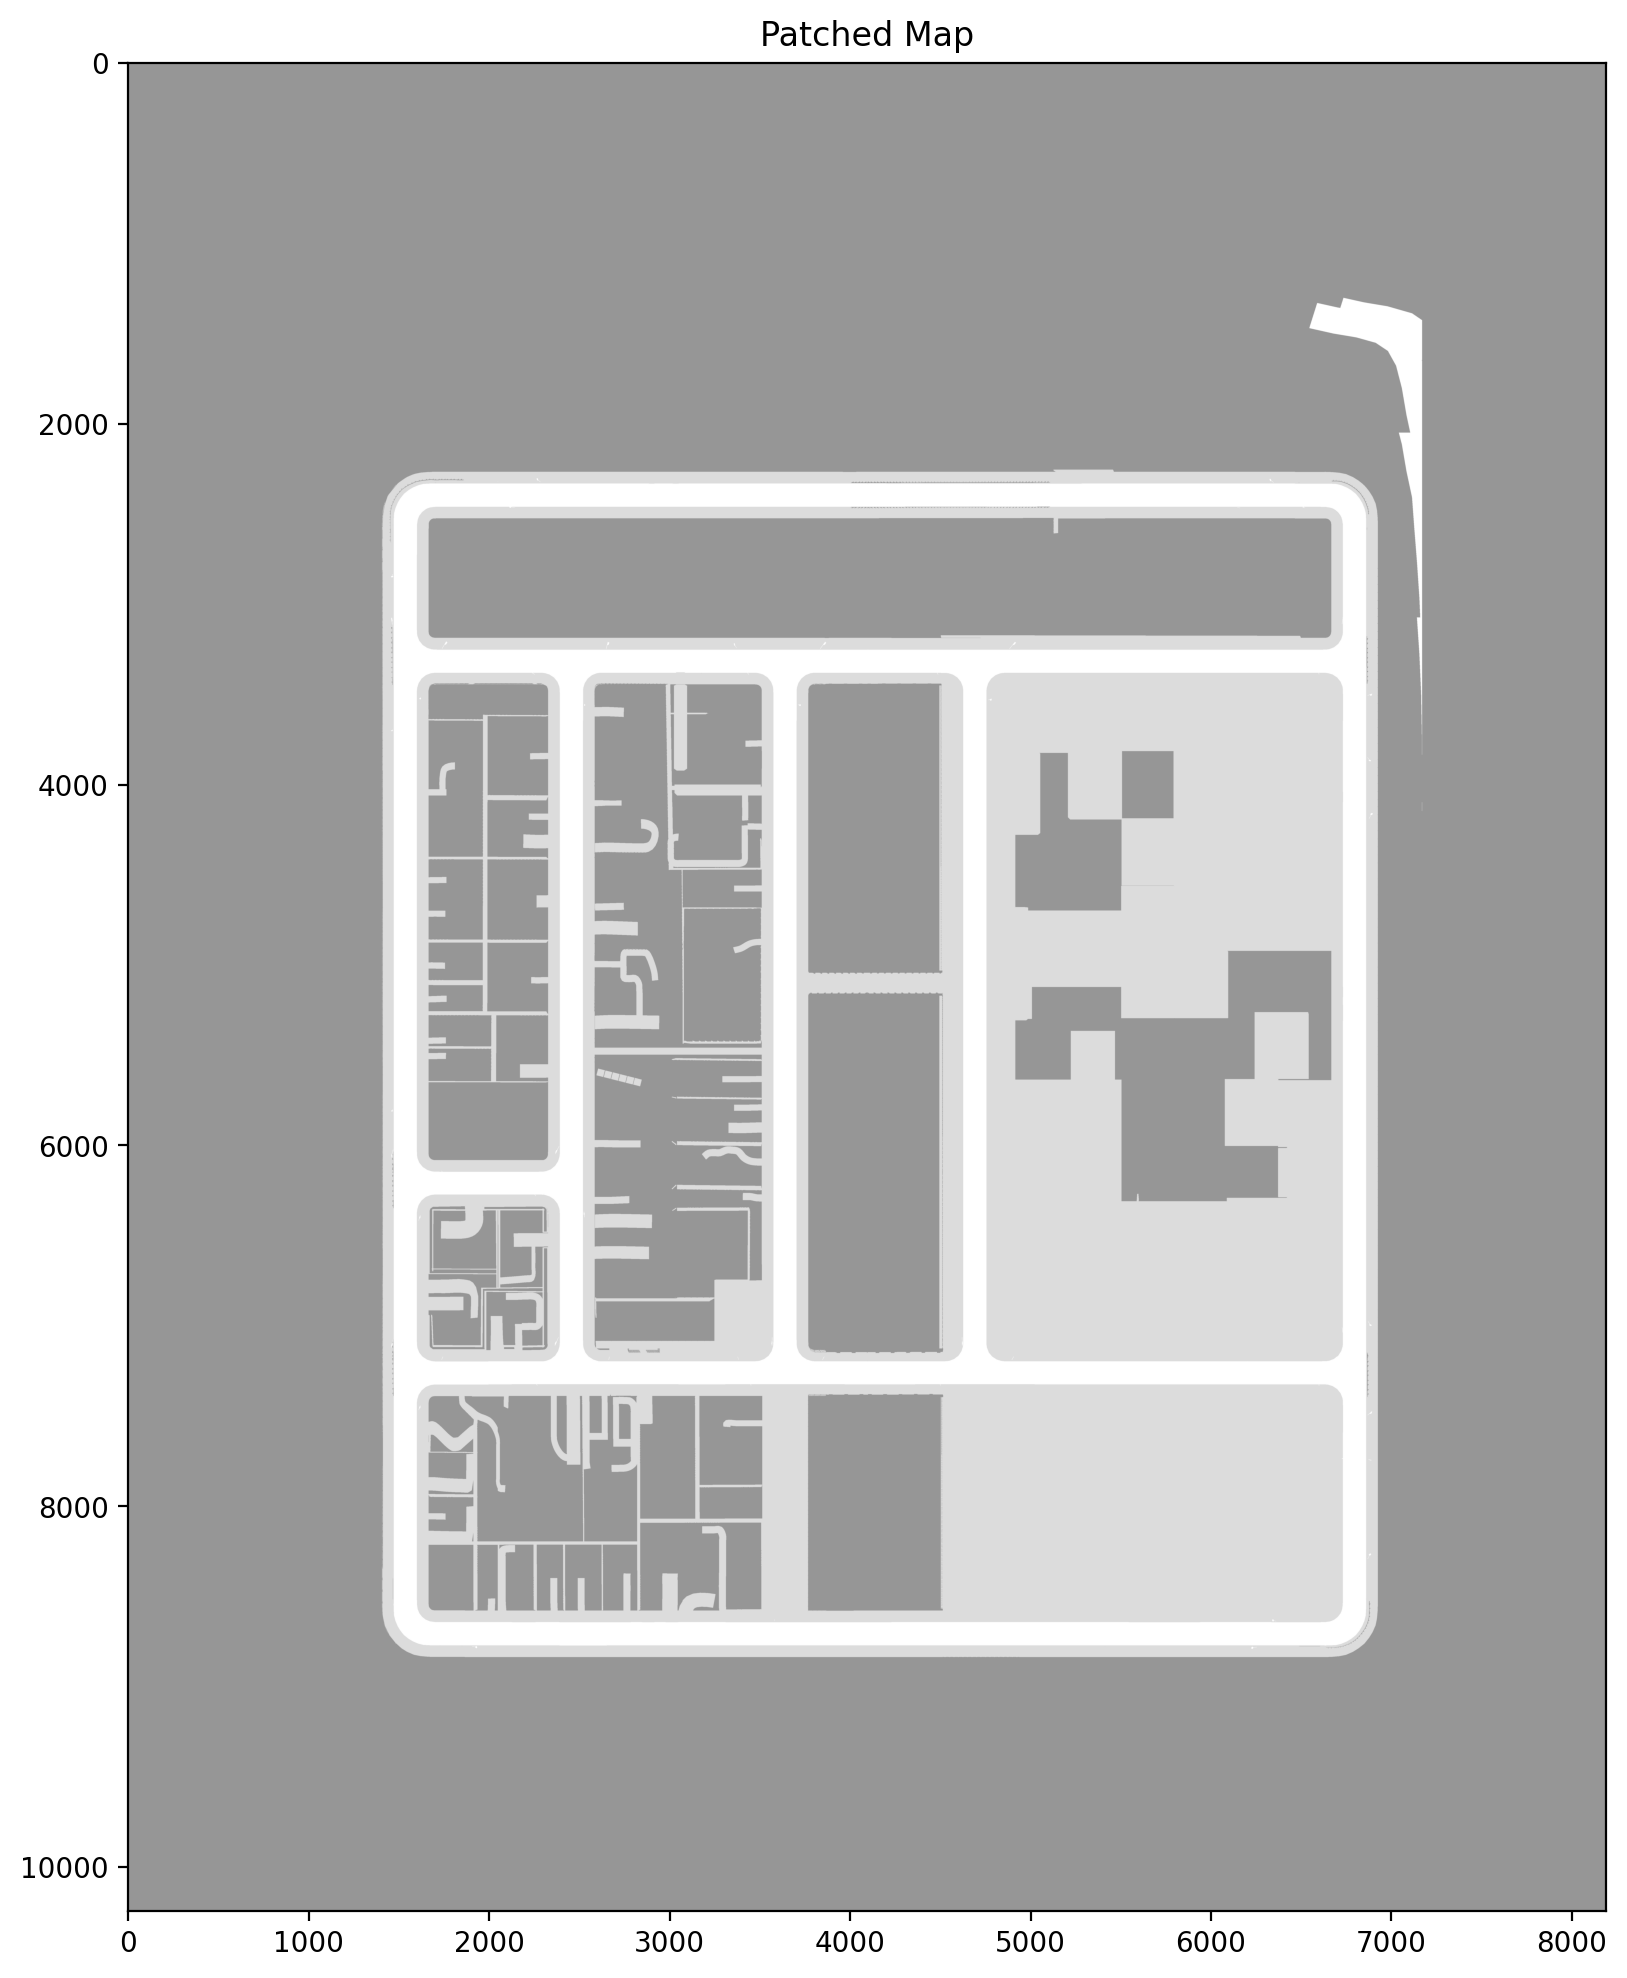

In [29]:
from CarlaBEV.envs.utils import load_map

rgbmap, _, _ = load_map(size=1024)

print(f"Image Size: {rgbmap.shape}")

# Example: Patch a white rectangle at (y0, x0) with height h and width w

# If rgbmap is float [0,1], use 1.0; if uint8 [0,255], use 255
if rgbmap.dtype == np.uint8:
    white = 255
else:
    white = 1.0

y0, x0 = 7409, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3466, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 7256, 3492    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3406, 4689    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

plt.imshow(rgbmap)
plt.title("Patched Map")
plt.show()

In [30]:
intersections = [
    (8642, 1564),
    (8654, 6755),
    (7250, 1552),
    (7241, 2446),
    (7242, 3652),
    (7242, 4704),
    (7257, 6773),
    (6199, 1552),
    (6197, 2439),
    (3349, 1545),
    (3350, 2456),
    (3350, 3639),
    (3335, 4714),
    (3315, 6773),
    (2456, 1563),
    (2446, 6757),
 ]

intersections = [(y, x) for x, y in intersections]

map_edges = {}
for i, coord in enumerate(intersections):
    x, y = coord
    map_edges[i] = (x, y)
    print(i, map_edges[i])

0 (1564, 8642)
1 (6755, 8654)
2 (1552, 7250)
3 (2446, 7241)
4 (3652, 7242)
5 (4704, 7242)
6 (6773, 7257)
7 (1552, 6199)
8 (2439, 6197)
9 (1545, 3349)
10 (2456, 3350)
11 (3639, 3350)
12 (4714, 3335)
13 (6773, 3315)
14 (1563, 2456)
15 (6757, 2446)


## GET CENTERLINE   

In [31]:
from skimage.color import rgb2gray
from skimage.morphology import skeletonize

def get_midlane_coords(rgbmap):
    gray = rgb2gray(rgbmap)
    binary = gray > 0.99  # Adjust threshold if needed
    # Skeletonize to get lane centerlines
    skeleton = skeletonize(binary)
    # Get coordinates of skeleton pixels (centerline points)
    centerline_coords = np.argwhere(skeleton)
    return centerline_coords

Direct intersection pairs (by index): [(0, 1), (0, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 5), (4, 11), (5, 6), (5, 12), (6, 13), (7, 8), (7, 9), (8, 10), (9, 10), (9, 14), (10, 11), (11, 12), (12, 13), (13, 15), (14, 15)]


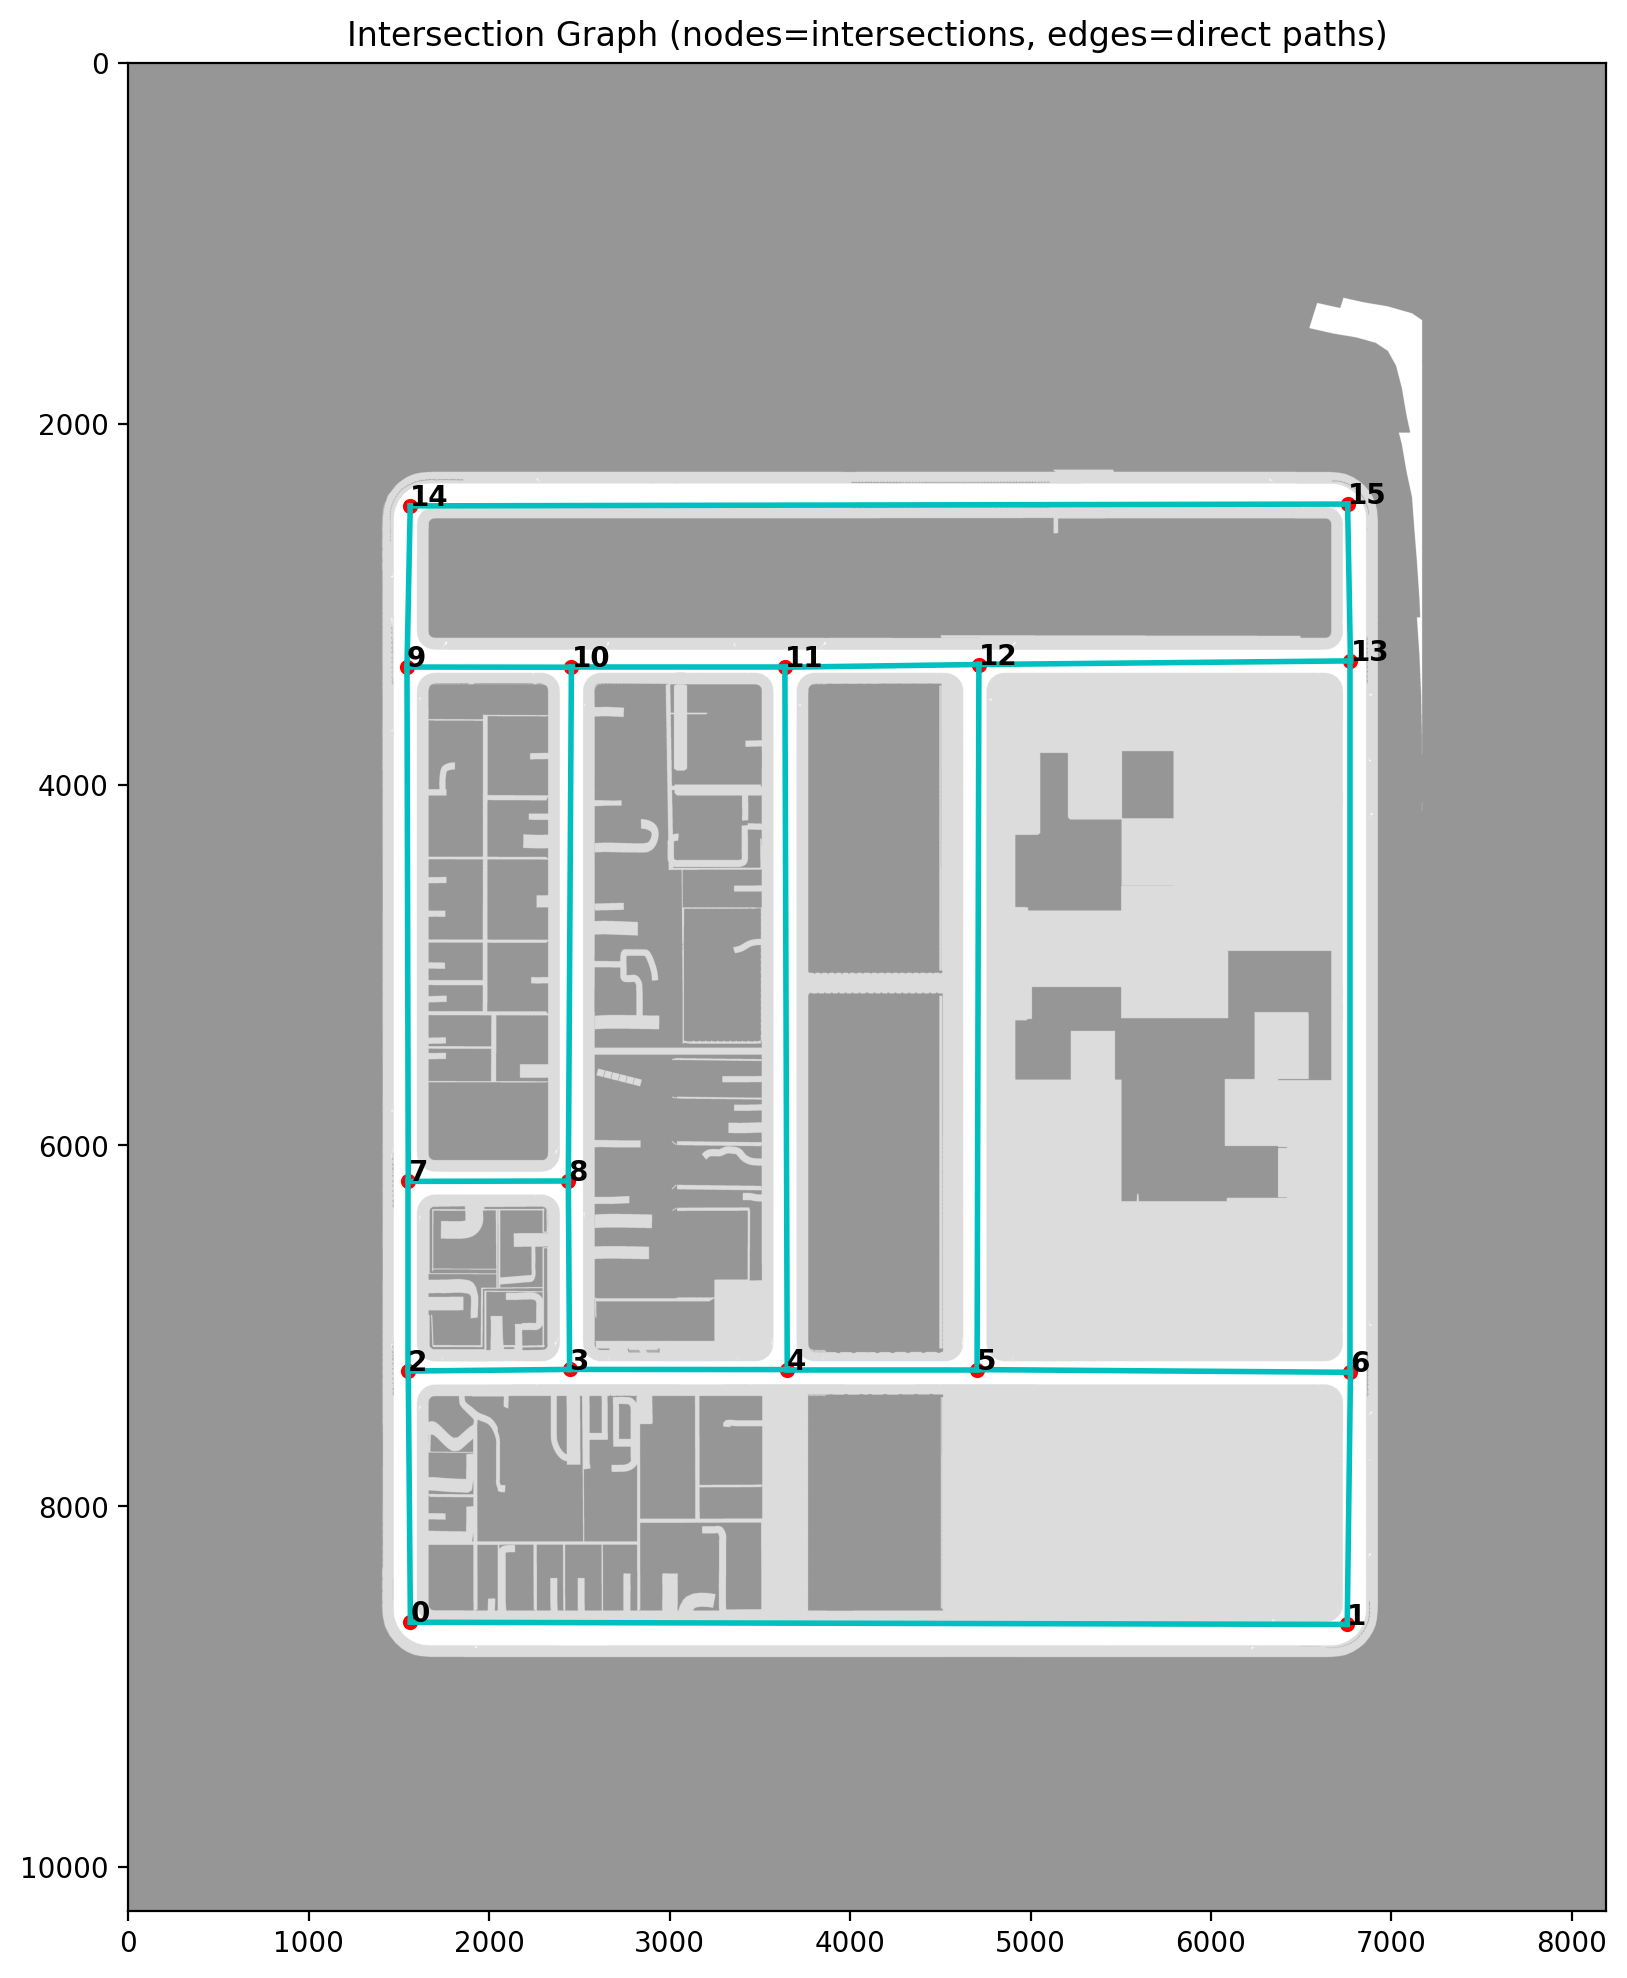

In [32]:
centerline_coords = get_midlane_coords(rgbmap)
centerline_coords = centerline_coords[:, [1, 0]]

# 1. Find the closest centerline point for each intersection
intersection_nodes = []
for intersection in intersections:
    dists = np.linalg.norm(centerline_coords - intersection, axis=1)
    idx_min = np.argmin(dists)
    intersection_nodes.append(tuple(centerline_coords[idx_min]))


# 2. Build a pixel adjacency graph for centerline_coords (for pathfinding only)
pixel_graph = nx.Graph()
centerline_set = set(map(tuple, centerline_coords))
for y, x in centerline_coords:
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            neighbor = (y + dy, x + dx)
            if neighbor in centerline_set:
                pixel_graph.add_edge((y, x), neighbor)

# 3. Precompute a set of "blocked" pixels for each intersection (within a radius)
block_radius = 50  # pixels
blocked_pixels = []
for node in intersection_nodes:
    y0, x0 = node
    pixels = set()
    for dy in range(-block_radius, block_radius+1):
        for dx in range(-block_radius, block_radius+1):
            if dy**2 + dx**2 <= block_radius**2:
                pixels.add((y0+dy, x0+dx))
    blocked_pixels.append(pixels)

# 4. Build the intersection graph
G_intersections = nx.Graph()
for idx in range(len(intersections)):
    G_intersections.add_node(idx, pos=intersections[idx])

for i, node_a in enumerate(intersection_nodes):
    for j, node_b in enumerate(intersection_nodes):
        if i < j:
            try:
                path = nx.shortest_path(pixel_graph, node_a, node_b)
                path_set = set(path[1:-1])
                blocked = False
                for k, block in enumerate(blocked_pixels):
                    if k != i and k != j and path_set & block:
                        blocked = True
                        break
                if not blocked:
                    G_intersections.add_edge(i, j)
            except nx.NetworkXNoPath:
                continue

print("Direct intersection pairs (by index):", list(G_intersections.edges))

# Visualization
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
for i, j in G_intersections.edges:
    a = intersections[i]
    b = intersections[j]
    plt.plot([a[0], b[0]], [a[1], b[1]], 'c-', lw=2)
plt.title("Intersection Graph (nodes=intersections, edges=direct paths)")
plt.show()

## Get Lanes

In [33]:
def sample_equidistant_points(path_coords, step=100):
    """Given a list of (y, x) coords, return equidistant points along the path."""
    path_coords = np.array(path_coords)
    # Compute cumulative distance along the path
    deltas = np.diff(path_coords, axis=0)
    dists = np.sqrt((deltas**2).sum(axis=1))
    cumdist = np.insert(np.cumsum(dists), 0, 0)
    total_dist = cumdist[-1]
    n_points = int(total_dist // step)
    if n_points < 2:
        return path_coords  # Path too short, return as is
    sample_dists = np.linspace(0, total_dist, n_points)
    sampled_points = np.empty((n_points, 2))
    sampled_points[0] = path_coords[0]
    sampled_points[-1] = path_coords[-1]
    j = 1
    for i in range(1, n_points-1):
        d = sample_dists[i]
        while cumdist[j] < d:
            j += 1
        ratio = (d - cumdist[j-1]) / (cumdist[j] - cumdist[j-1])
        sampled_points[i] = path_coords[j-1] + ratio * (path_coords[j] - path_coords[j-1])
    return sampled_points.astype(int)


In [34]:
def compute_lane_offsets(waypoints, lane_width=6.0):
    """
    Given centerline waypoints (N,2), return left and right lane waypoints.
    lane_width: total width of both lanes (in pixels, adjust as needed)
    """
    waypoints = np.array(waypoints)
    left_lane = []
    right_lane = []
    side_1, side_2 = [], []
    offset = lane_width / 2.0
    offset_ped = lane_width + 10

    for i in range(len(waypoints)):
        # Compute direction vector
        if i == 0:
            direction = waypoints[i+1] - waypoints[i]
        elif i == len(waypoints) - 1:
            direction = waypoints[i] - waypoints[i-1]
        else:
            direction = waypoints[i+1] - waypoints[i-1]
        direction = direction / np.linalg.norm(direction)
        # Normal vector (perpendicular, 2D)
        normal = np.array([-direction[1], direction[0]])
        # Offset points
        left_lane.append(waypoints[i] + offset * normal)
        right_lane.append(waypoints[i] - offset * normal)
        side_1.append(waypoints[i] + offset_ped * normal)
        side_2.append(waypoints[i] - offset_ped * normal)
    return np.array(left_lane), np.array(right_lane), np.array(side_1), np.array(side_2)


In [151]:
# Usage
lane_width_pixels = 80  # Adjust to your map's scale

segment_info = {}
wrong_lanes = ["0->2", "2->3", "3->4", "4->5", "5->6", "2->7",
         "7->8", "7->9", "9->10", "10->11", "11->12", "12->13", "9->14", "14->15"]

for i, j in list(G_intersections.edges):
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
    # Get the pixel path between intersections
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    # Sample equidistant points (e.g., every n pixels)
    waypoints = sample_equidistant_points(path, step=100)

    right_lane, left_lane, _, _ = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)
    direction = "j->i" if f"{i}->{j}" in wrong_lanes else "i->j"
    # Store metadata
    segment_info[(i, j)] = {
        "centerline": waypoints,
        "L": left_lane,
        "R": right_lane,
        "direction": direction,  # default
    }
    if direction == "j->i":
        segment_info[(i, j)]["L"], segment_info[(i, j)]["R"] = right_lane, left_lane
    
    print((i, j), direction)

(0, 1) i->j
(0, 2) j->i
(1, 6) i->j
(2, 3) j->i
(2, 7) j->i
(3, 4) j->i
(3, 8) i->j
(4, 5) j->i
(4, 11) i->j
(5, 6) j->i
(5, 12) i->j
(6, 13) i->j
(7, 8) j->i
(7, 9) j->i
(8, 10) i->j
(9, 10) j->i
(9, 14) j->i
(10, 11) j->i
(11, 12) j->i
(12, 13) j->i
(13, 15) i->j
(14, 15) j->i


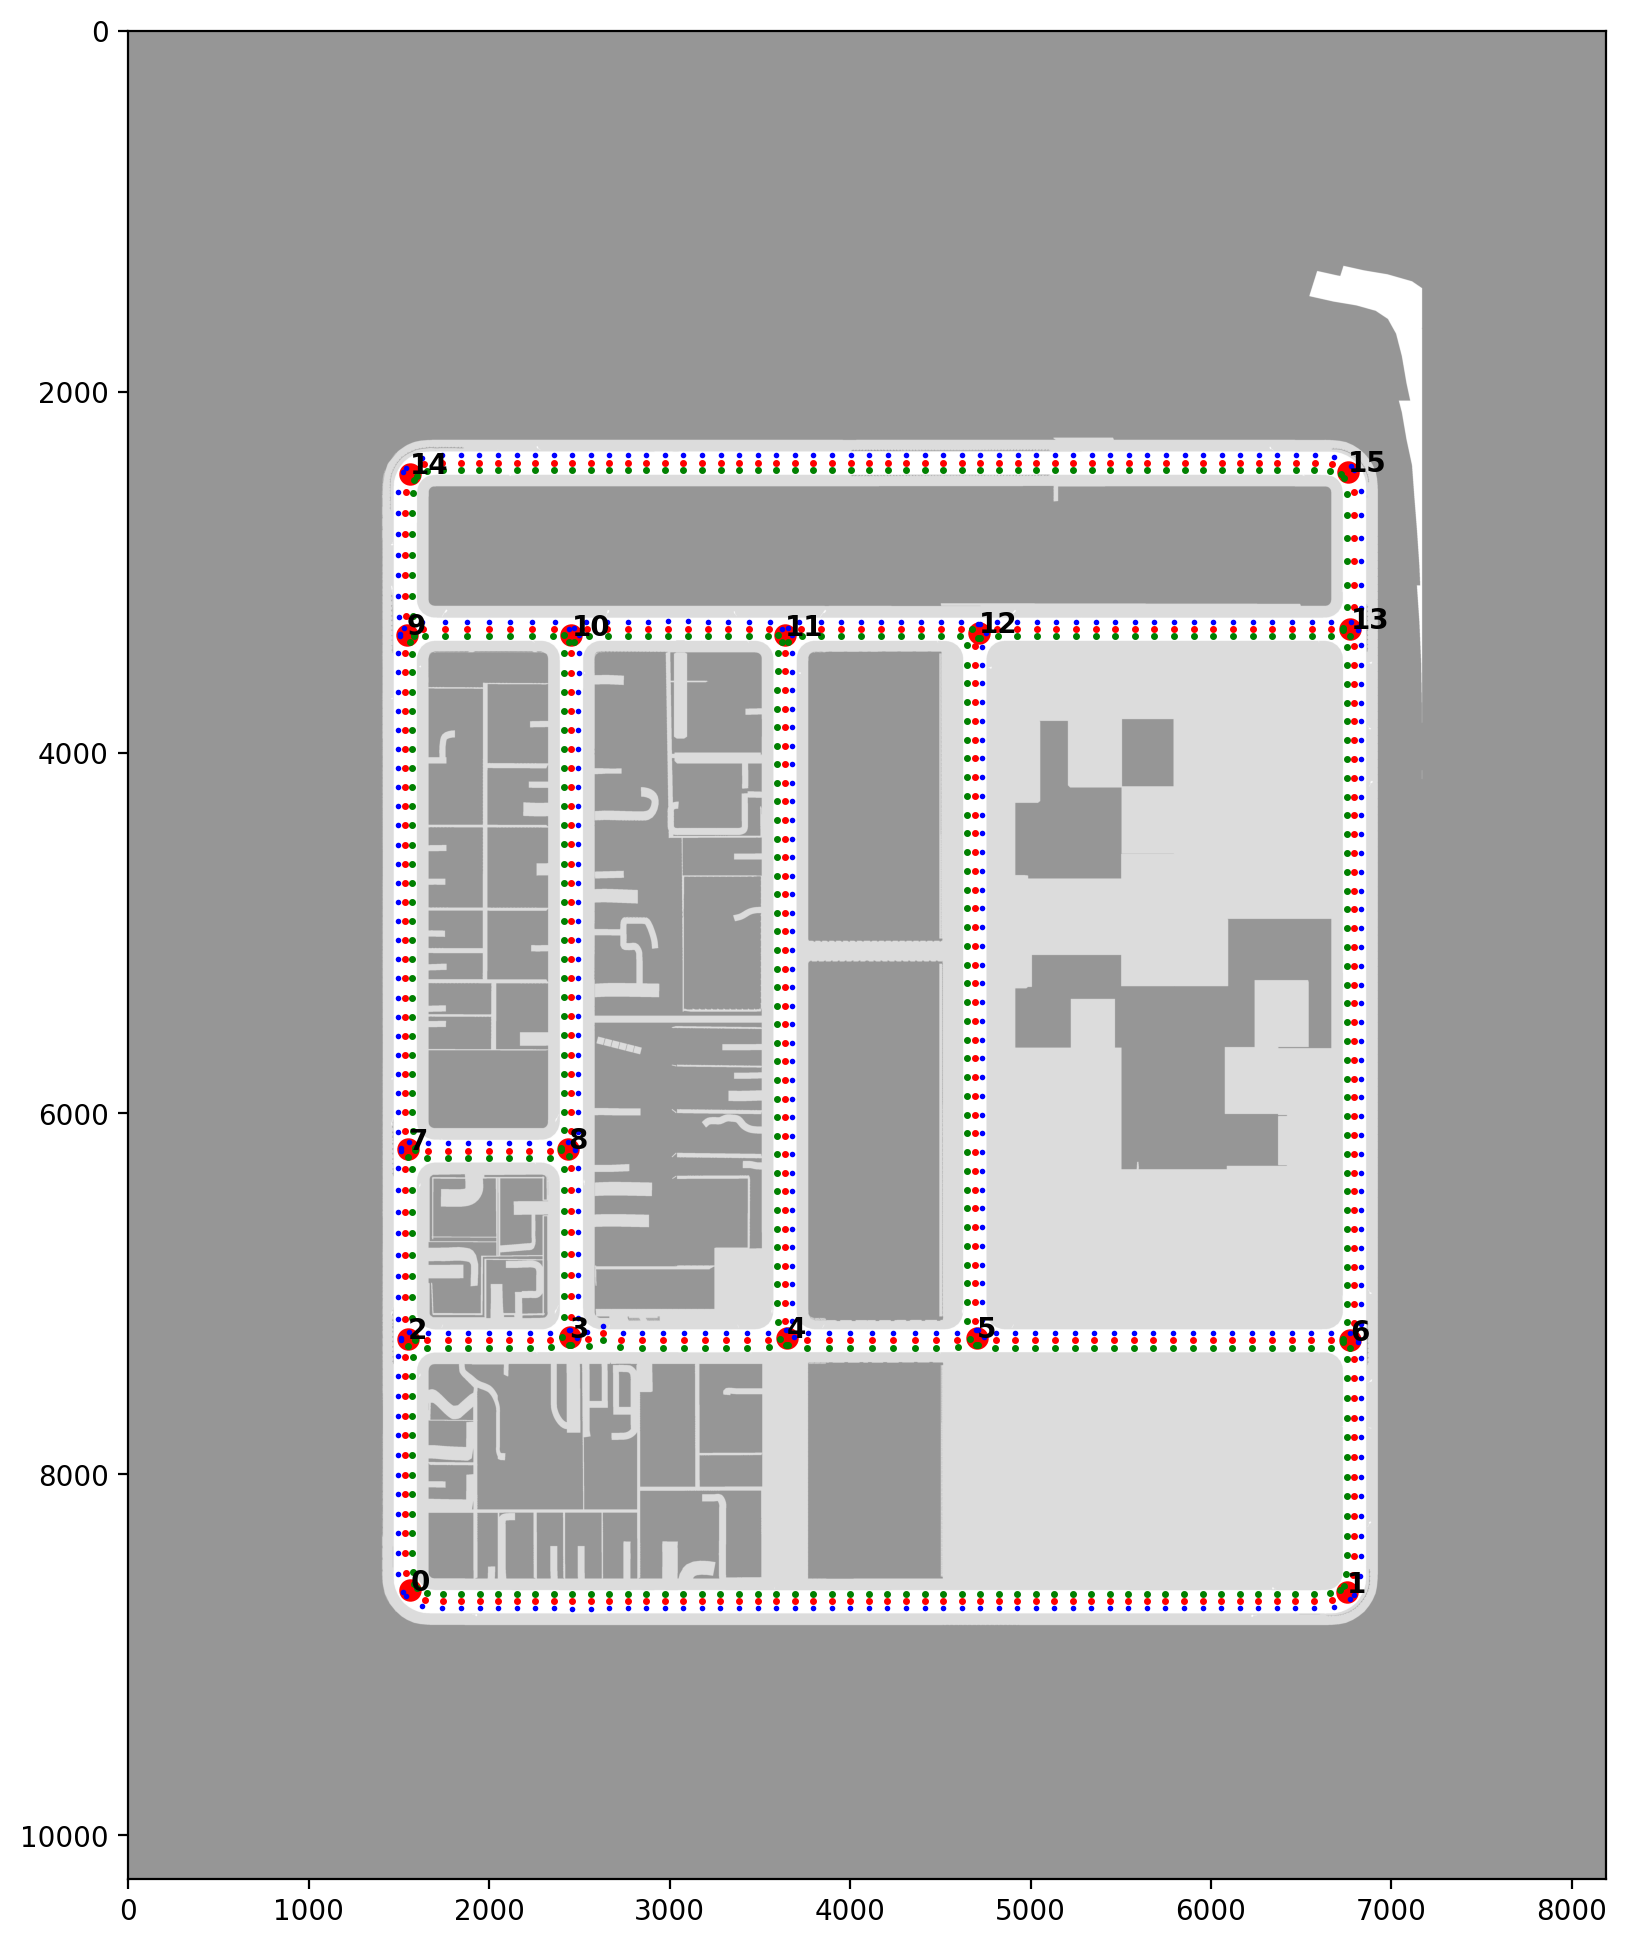

In [152]:
# Visualize one edge's waypoints
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for segment in segment_info.keys():
    waypoints = segment_info[segment]["centerline"]
    left = segment_info[segment]["L"]
    right = segment_info[segment]["R"]
    plt.plot(left[:,0], left[:,1], 'g.', markersize=3)
    plt.plot(waypoints[:,0], waypoints[:,1], 'r.', markersize=3)
    plt.plot(right[:,0], right[:,1], 'b.', markersize=2)

for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')

## HELPER FUNCTIONS

In [153]:
def get_route_waypoints(pixel_graph, node_a, node_b ):
    # 2. For each consecutive pair, find pixel path and discretize
    pixel_path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(pixel_path, step=300)  # step in pixels
    return waypoints

In [165]:
def add_lane_segment(G, seg_id, direction, lane_points, lane_type, step_cost=1.0, conn_cost=0.3):
    """
    Adds waypoints for a segment lane and connects them.
    Right lane: from a → b (unless direction is flipped)
    Left lane: from b → a (unless direction is flipped)
    """
    a, b = seg_id
    if len(lane_points) < 2:
        return G

    lane_label = "R" if lane_type == "R" else "L"

    # Handle direction flip
    if direction == "j->i":
        a, b = b, a  # swap endpoints
        lane_points = list(reversed(lane_points))

    # Define order: right → forward, left → reversed
    if lane_type == "R":
        ordered_points = lane_points
        start_inter, end_inter = f"intersection_{a}", f"intersection_{b}"
    else:  # left lane flows backward
        ordered_points = list(reversed(lane_points))
        start_inter, end_inter = f"intersection_{b}", f"intersection_{a}"

    # Create intersection nodes (ensure position consistency)
    G.add_node(start_inter, pos=ordered_points[0], type="intersection")
    G.add_node(end_inter, pos=ordered_points[-1], type="intersection")

    # Create nodes for waypoints
    n_nodes = len(ordered_points)
    node_ids = []
    for i, pt in enumerate(ordered_points):
        node_id = f"{a}_{b}_{lane_label}_{i}"
        G.add_node(node_id, pos=pt, lane=lane_type, segment=(a, b))
        node_ids.append(node_id)

    # Connect internal waypoints
    for u, v in zip(node_ids[:-1], node_ids[1:]):
        G.add_edge(u, v, cost=step_cost, lane=lane_type)

    return G



def connect_segment_endpoints(G, seg_id, lane_type, map_data, step_cost=0.3):
    """
    Connects segment endpoints to neighbor segments in the correct direction.
    Enforces edge direction consistent with lane.
    """
    lane_type_short = lane_type[:1].upper()
    lane_points = map_data[seg_id][lane_type]
    if len(lane_points) < 2:
        return G

    # Segment direction
    direction = map_data[seg_id]["direction"]
    i, j = seg_id
    if direction == "j->i":
        i, j = j, i  # adjust for naming
    edge_label = f"{i}_{j}_{lane_type_short}"
    start_node = f"{edge_label}_0"
    end_node = f"{edge_label}_{len(lane_points)-1}"

    # --- Connect to previous segments (upstream) ---
    for prev_seg in map_data[seg_id].get("prev_segments", []):
        prev_points = map_data[prev_seg][lane_type]
        if len(prev_points) < 2:
            continue
        pi, pj = prev_seg
        if map_data[prev_seg]["direction"] == "j->i":
            pi, pj = pj, pi
        prev_end_node = f"{pi}_{pj}_{lane_type_short}_{len(prev_points)-1}"
        if prev_end_node in G.nodes:
            G.add_edge(prev_end_node, start_node, cost=step_cost, lane_dir="forward")

    # --- Connect to next segments (downstream) ---
    for next_seg in map_data[seg_id].get("next_segments", []):
        next_points = map_data[next_seg][lane_type]
        if len(next_points) < 2:
            continue
        ni, nj = next_seg
        if map_data[next_seg]["direction"] == "j->i":
            ni, nj = nj, ni
        next_start_node = f"{ni}_{nj}_{lane_type_short}_0"
        if next_start_node in G.nodes:
            G.add_edge(end_node, next_start_node, cost=step_cost, lane_dir="forward")

    return G


## Build Graph

In [161]:
# Deepcopy to avoid modifying original segment_info
segment_info_copy = deepcopy(segment_info)

# Example correction list
directions = {
    "i->j": [(12, 13)],                # segments that should go from i to j
    "j->i": [(1, 6)]  # segments that need to be flipped
}

# Flip segments in the dictionary
for desired_direction, seg_list in directions.items():
    for seg_id in seg_list:
        if seg_id not in segment_info_copy:
            print(f"⚠️ Segment {seg_id} not found, skipping.")
            continue

        current_dir = segment_info_copy[seg_id].get("direction", "i->j")

        if current_dir != desired_direction:
            # Flip the direction metadata
            segment_info_copy[seg_id]["direction"] = desired_direction

            # Reverse the lane points
            for lane_key in ["R", "L", "right_lane", "left_lane"]:
                if lane_key in segment_info_copy[seg_id]:
                    segment_info_copy[seg_id][lane_key] = list(
                        reversed(segment_info_copy[seg_id][lane_key])
                    )

            print(f"🔁 Flipped segment {seg_id} to {desired_direction}")


🔁 Flipped segment (12, 13) to i->j
🔁 Flipped segment (1, 6) to j->i


In [166]:
# Deepcopy to avoid modifying original segment_info
map_data = deepcopy(segment_info_copy)

# Initialize lane graphs
G_left = nx.DiGraph()
G_right = nx.DiGraph()

for seg_id, seg_data in map_data.items():
    add_lane_segment(G_right, seg_id, seg_data["R"], "R")
    add_lane_segment(G_left,  seg_id, seg_data["L"], "L")

# Combined graph if needed
G_combined = nx.compose(G_left, G_right)

# --- Connect segments ---
for seg_id, seg_data in map_data.items():
    for lane_type, G in zip(["L", "R"], [G_left, G_right]):
       # G = connect_segment_endpoints(G, seg_id, lane_type[:1].upper(), map_data)
       pass

# --- Visualization ---
pos = {n: G_right.nodes[n]['pos'] for n in G_right.nodes}
nx.draw(G_right, pos=pos, node_size=20, node_color='blue', edge_color='gray')


TypeError: add_lane_segment() missing 1 required positional argument: 'lane_type'

In [163]:
seg_id = (12, 13)
seg_data = segment_info_copy[seg_id]
a, b = seg_id
print(f"{seg_id} {seg_data['direction']}")
print(f"  R start: {seg_data['R'][0]}, end: {seg_data['R'][-1]}")
print(f"  L start: {seg_data['L'][0]}, end: {seg_data['L'][-1]}")

(12, 13) i->j
  R start: [6773.3773417  3275.00177987], end: [4708.9911935  3287.31484084]
  L start: [6772.6226583  3354.99822013], end: [4719.0088065  3366.68515916]


(0, 1) j->i
(0, 1) j->i
(0, 2) j->i
(0, 2) j->i
(1, 6) i->j
(1, 6) i->j
(2, 3) j->i
(2, 3) j->i
(2, 7) j->i
(2, 7) j->i
(3, 4) j->i
(3, 4) j->i
(3, 8) i->j
(3, 8) i->j
(4, 5) j->i
(4, 5) j->i
(4, 11) i->j
(4, 11) i->j
(5, 6) j->i
(5, 6) j->i
(5, 12) i->j
(5, 12) i->j
(6, 13) i->j
(6, 13) i->j
(7, 8) j->i
(7, 8) j->i
(7, 9) j->i
(7, 9) j->i
(8, 10) i->j
(8, 10) i->j
(9, 10) j->i
(9, 10) j->i
(9, 14) j->i
(9, 14) j->i
(10, 11) j->i
(10, 11) j->i
(11, 12) j->i
(11, 12) j->i
(12, 13) j->i
(12, 13) j->i
(13, 15) i->j
(13, 15) i->j
(14, 15) j->i
(14, 15) j->i


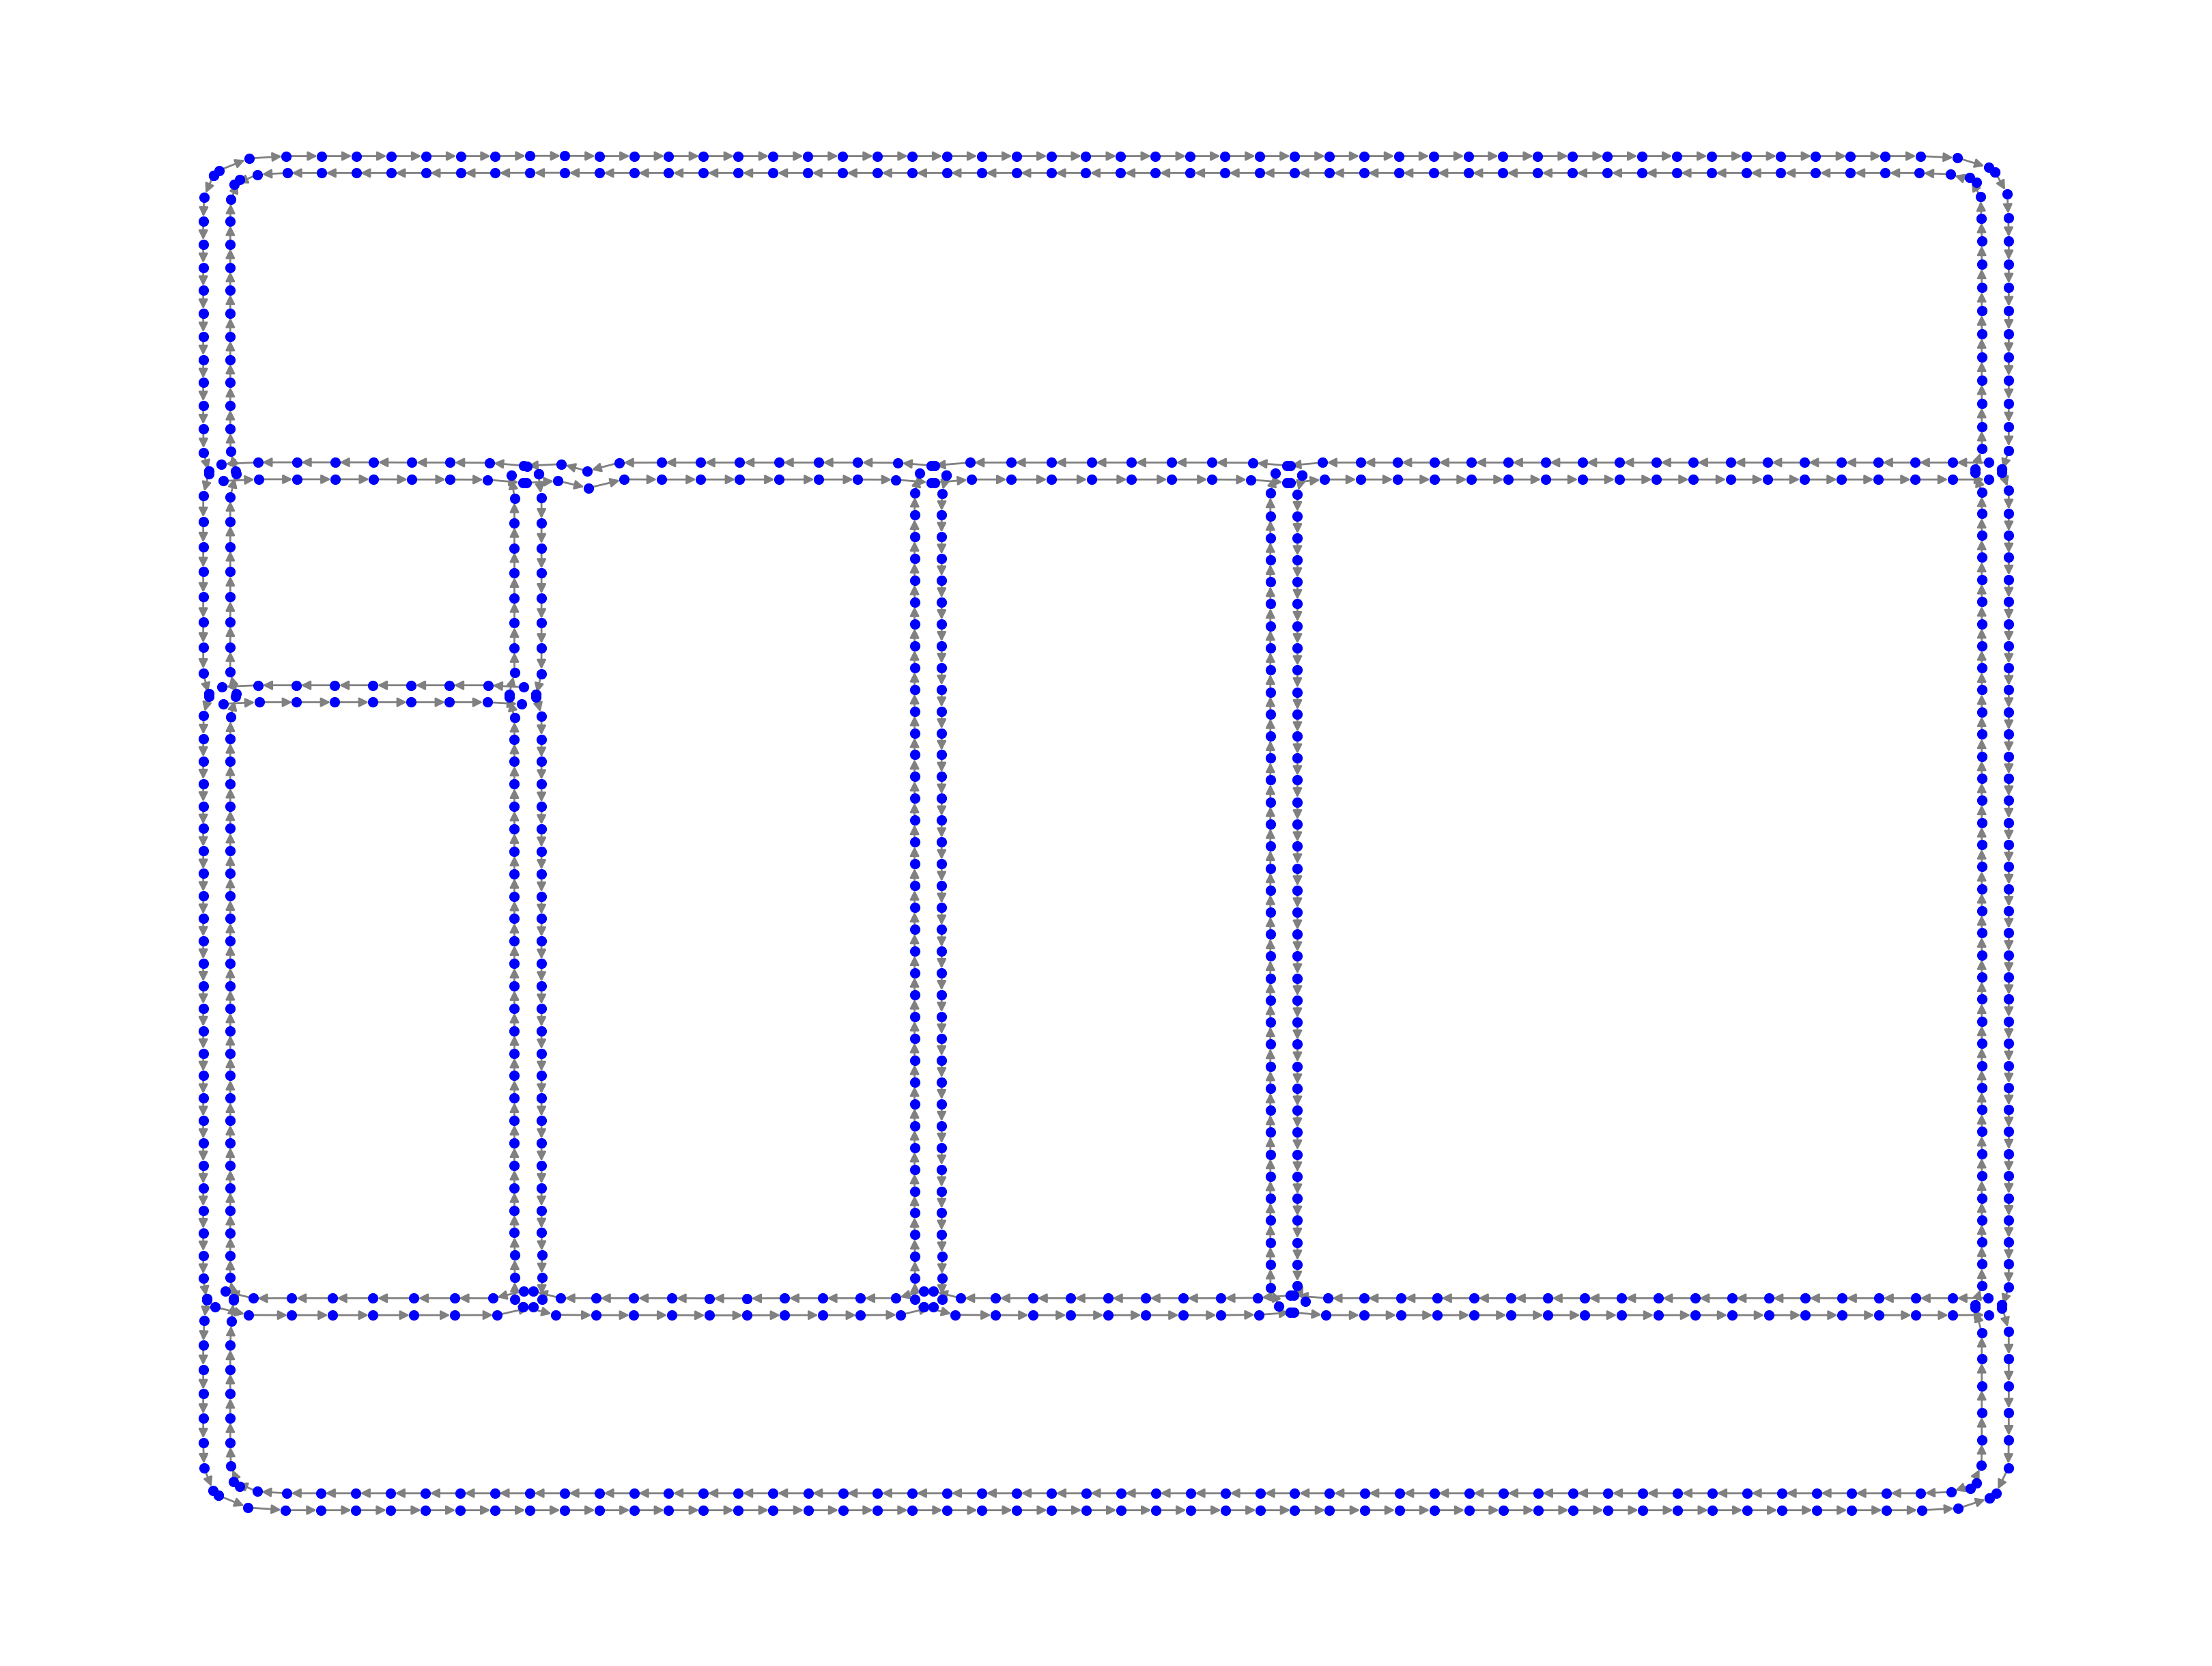

In [93]:

# --- Visualization ---
pos = {n: G_combined.nodes[n]['pos'] for n in G_combined.nodes}
nx.draw(G_combined, pos=pos, node_size=20, node_color='blue', edge_color='gray')
